## A Calibrated Measurement of the Near-IR Continuum Sky Brightness Using Magellan/FIRE  

We want to compare our results to those published in Sullivan and Simcoe. 

In [1]:
%matplotlib inline
import os, sys, glob, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy import interpolate
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import EarthLocation
import speclite.filters
from astropy import units as u
from scipy import integrate
from speclite.filters import ab_reference_flux

In [2]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

In [3]:
DATA_DIR = '/Volumes/PFagrelius_Backup/sky_data/'

## Their Results

In [5]:
#Inter-line continuum levels during dark sky in mag/arcsec^2
Y_ab = 20.05 #+/- 0.04

#### Convert to Flux units

In [6]:
def static_abmag_to_flux(mag, wave):
    """Calcuates flux in 10**-17 erg/s/cm2/A. If the magnitude is quoted per arcsec^2, 
    the BOSS fiber area of pi arcsec^2 is multiplied.
    """
    zero_point = 3631 #Jy
    w = wave*10 #angstroms
    f_nu = zero_point*(10**(-0.4*mag)) #Jansky
    f_lam = f_nu/(3.34*10**4)*(1/(w**(2)))
    f_lam = f_lam*10**17 #10^-17 erg/s/cm2/A/arcsec2
    f_lam = f_lam * np.pi #10^-17 erg/s/cm2/A
    print("unit: 10^-17/erg/s/cm2/A")
    return f_lam

In [7]:
def static_flux_to_abmag(flux, wave, per_arcsec2 =True):
    """Converts flux in 10^-17 erg/s/cm2/A to mag or mag/arcsec^2
    """
    w = wave*10 #angstrom
    flux = flux*10**(-17)
    if per_arcsec2:
        flux = flux/np.pi
    f_nu = flux * (w**2) * 3.34*10**4
    mag = -2.5*np.log10(f_nu/3631)
    return mag

In [8]:
def abmag_to_flux(mag, filter_curve):
    #Integrate the abmag over the filter curve
    zero_point = 3631 #Jy
    hc = 1.23984193 #ev*um
    f_lam = np.pi*(10**(-0.4*mag))
    f_nu = lambda w: zero_point/(3.34*10**4)*(1/(w**(2)))*((w/10000)/hc)*filter_curve(w)
    norm = lambda w: filter_curve(w)*((w/10000)/hc)
    a = integrate.quad(f_nu, 0, 100000)
    b = integrate.quad(norm, 0, 100000)
    flux = f_lam*(a[0]/b[0])* u.erg / (u.cm**2 * u.s * u.Angstrom)
    return flux

In [9]:
static_abmag_to_flux(Y_ab, 1020)

unit: 10^-17/erg/s/cm2/A


3.1349405633330676

In [22]:
abmag_to_flux(Y_ab, Y_trans)

/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


<Quantity 3.1287493791030727e-17 erg / (Angstrom cm2 s)>

In [106]:
# Check with Kirkby's code

In [16]:
fs = ['lsst2016-y', 'decam2014-Y','vista-Y']


In [24]:
for f in fs:
    ff = speclite.filters.load_filter(f)
    num = ff.convolve_with_function(ab_reference_flux)
    den = ff.convolve_with_function(lambda wlen: u.Quantity(1))
    print("%s: %s" %(f, np.pi*(10**(-0.4*Y_ab))*(num/den)))

lsst2016-y: 3.467766612694497e-17 erg / (Angstrom cm2 s)
decam2014-Y: 3.3546443796919613e-17 erg / (Angstrom cm2 s)
vista-Y: 3.132960472221715e-17 erg / (Angstrom cm2 s)


### Zodiacal Light

According to the paper, HST/NICMOS meausured the zodiacal light to be on average 22.4 ABmag/arcsec^2

In [46]:
Z_AB = 22.4 #ab mag/arcsec^2 @ 1020

In [47]:
static_abmag_to_flux(Z_AB, 1020)

unit: 10^-17/erg/s/cm2/A


0.35993933609683587

## Pick out Dark Data

In [4]:
meta_dir = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/dark_meta_rich.npy'
Meta_Data = np.load(meta_dir)

In [5]:
Meta_Data = Meta_Data[Meta_Data['MOON_SEP']>90]

In [6]:
APACHE = EarthLocation.of_site('Apache Point')

In [7]:
hour = [tt.datetime.hour for tt in Time(Meta_Data['TAI-BEG']/86400., scale='tai', format='mjd', location=APACHE)] 

In [8]:
dark_time = np.where((np.array(hour)<=2)|(np.array(hour)>=10))

In [9]:
MetaData = Meta_Data[dark_time]

In [32]:
len(np.unique(MetaData["IMG"]))

65

In [10]:
Red_Data = MetaData[(MetaData['CAMERAS'] == b'r1') | (MetaData['CAMERAS'] == b'r2')]
Blue_Data = MetaData[(MetaData['CAMERAS'] == b'b1') | (MetaData['CAMERAS'] == b'b2')]

In [11]:
len(np.unique(Red_Data['PLATE']))

36

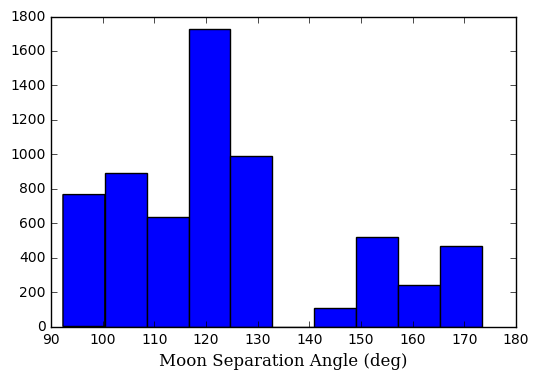

In [12]:
plt.hist(Red_Data['MOON_SEP'],bins = 10)
plt.xlabel('Moon Separation Angle (deg)', fontproperties=font)

In [13]:
print(len(np.unique(Red_Data['IMG'])))
print(len(Red_Data))

65
6347


In [14]:
#Get one random spectrum to check out
def get_spectrum():
    plate = np.random.choice(np.unique(Red_Data['PLATE']),1)[0]
    print("plate: ",plate)
    ThisData = np.random.choice(Red_Data[Red_Data['PLATE'] == plate],1)[0]
    specno = ThisData['SPECNO']

    data = np.load(DATA_DIR+'sky_flux/%s_calibrated_sky.npy' % str(plate))
    spectrum = data[specno]
    return spectrum

## Y-band

In [15]:
# Vista Y-band filter
Y_curve = np.loadtxt('/Users/parkerf/Downloads/Filters_QE_Atm_curves/VISTA_Filters_at80K_forETC_Y.dat')

In [24]:
Y_curve

array([[  5.00000000e+02,   6.00000000e-04],
       [  5.01000000e+02,   0.00000000e+00],
       [  5.02000000e+02,   1.20000000e-03],
       ..., 
       [  3.19693000e+03,   2.87300000e-01],
       [  3.19898000e+03,   2.69400000e-01],
       [  3.20102000e+03,   2.55700000e-01]])

In [16]:
def Y_trans(xx):
    curve = interp1d(Y_curve[:,0], Y_curve[:,1]/100., bounds_error=False, fill_value=0)
    return curve(xx)

In [17]:
def get_cont_segment(spectrum, low, high, y_curve = False):
    f = interp1d(spectrum['WAVE'], spectrum['CONT'], bounds_error=False, fill_value=0)
    xx = np.linspace(565, 1040, (1040-565)*100)
    sky = f(xx)
    if y_curve:
        sky = sky*Y_trans(xx)
    segment = sky[(low<=xx) & (xx<=high)]
    sky_mean = np.mean(segment)

    return sky_mean

plate:  7109


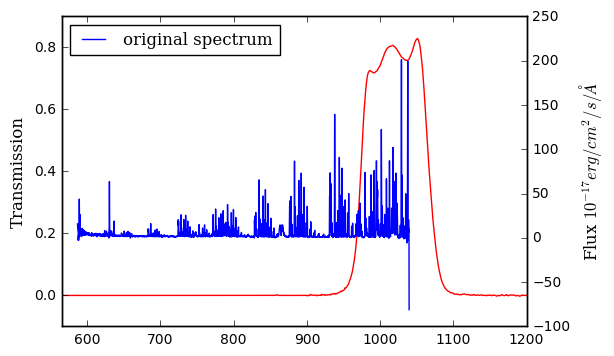

In [39]:
spectrum = get_spectrum()
fig, ax1 = plt.subplots()
ax1.plot(Y_curve[:,0], Y_curve[:,1]/100.,'r-',label='Y curve')
ax2 = ax1.twinx()
ax2.plot(spectrum['WAVE'], spectrum['SKY'],label='original spectrum')
plt.xlabel("Wavelength (nm)")#
plt.xlim([565, 1200])
#ax1.legend(loc=1)
ax2.legend(loc=2,prop=font)
plt.xlabel("Wavelength (nm)",fontproperties=font)
ax1.set_ylabel("Transmission",fontproperties=font)
ax2.set_ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$",fontproperties=font)

In [85]:
#Which filter?

In [18]:
Y_curve[:,1][np.where(Y_curve[:,1]/100. < 0)] = 0
Y_curve[:,1][np.where((Y_curve[:,0]<600)|(Y_curve[:,0]>2000))] = 0

In [19]:
angs_g = speclite.filters.FilterResponse(
    wavelength = Y_curve[:,0]*10 * u.Angstrom,
    response = Y_curve[:,1]/100., meta=dict(group_name='vista', band_name='Y'))

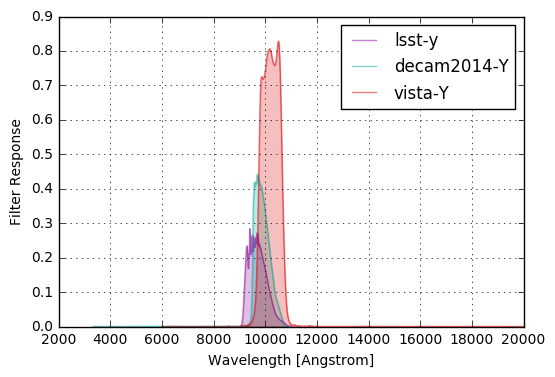

In [20]:
filters = speclite.filters.load_filters('lsst2016-y', 'decam2014-Y','vista-Y')
speclite.filters.plot_filters(filters)

In [20]:
cont_bands = [[976,978],[985.6,986.6],[992.5,993.5],[998.5,999.5],[1025,1026]]

(0, 250)

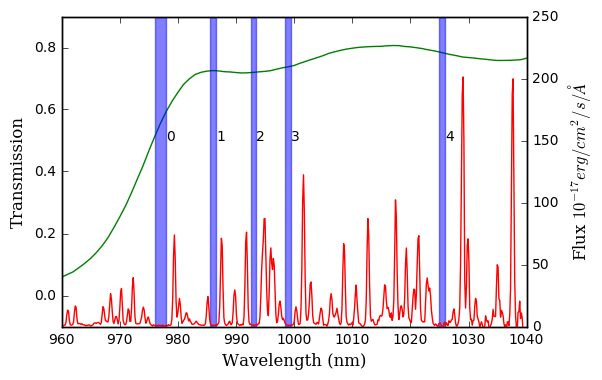

In [41]:
fig, ax1 = plt.subplots()
ax1.plot(Y_curve[:,0], Y_curve[:,1]/100.,'g-')
ax2 = ax1.twinx()
ax2.plot(spectrum['WAVE'], spectrum['SKY'],'r-')
plt.xlabel("Wavelength (nm)")#
for i, band in enumerate(cont_bands):
    plt.axvspan(band[0], band[1], alpha = 0.5, color = 'blue')
    plt.text(band[1], 150, i)
plt.xlim([960, 1040])
ax1.set_xlabel("Wavelength (nm)",fontproperties=font)
ax1.set_ylabel("Transmission",fontproperties=font)
ax2.set_ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$",fontproperties=font)
ax2.set_ylim([0,250])

(0, 10)

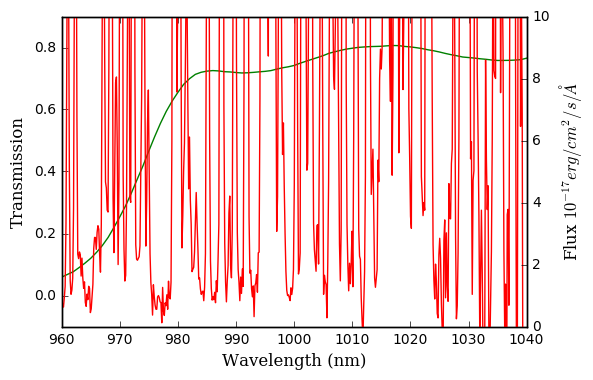

In [45]:
fig, ax1 = plt.subplots()
ax1.plot(Y_curve[:,0], Y_curve[:,1]/100.,'g-')
ax2 = ax1.twinx()
ax2.plot(spectrum['WAVE'], spectrum['SKY'],'r-')
plt.xlabel("Wavelength (nm)")#
#for i, band in enumerate(cont_bands):
#    plt.axvspan(band[0], band[1], alpha = 0.5, color = 'blue')
#    plt.text(band[1], 150, i)
plt.xlim([960, 1040])
ax1.set_xlabel("Wavelength (nm)",fontproperties=font)
ax1.set_ylabel("Transmission",fontproperties=font)
ax2.set_ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$",fontproperties=font)
ax2.set_ylim([0,10])

## Calculate Continuum Flux between lines

In [21]:
def get_sky_segment(spectrum, low, high, mean_spec = False):
    if mean_spec:
        f = interp1d(spectrum[0], spectrum[1], bounds_error=False, fill_value=0)
    else:
        f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
    xx = np.linspace(565, 1040, (1040-565)*100)
    sky = f(xx)
        
    segment = np.where((low<=xx) & (xx<=high))
    sky_mean = np.mean(sky[segment])

    return sky_mean

In [22]:
def mean_flux(spectrum, bands, y_band = False, mean_spec=False):
    Y = []
    S = []
    for band in bands:
        if mean_spec:
            f = interp1d(spectrum[0], spectrum[1], bounds_error=False, fill_value=0)
        else:
            f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
        xx = np.linspace(565, 1040, (1040-565)*100)
        sky = f(xx)
        segment = np.where((band[0]<=xx) & (xx<=band[1]))
        S.append(np.mean(sky[segment]))
        Y.append(np.mean(Y_trans(xx)[segment]))
    if y_band:
        mean = np.sum(np.array(S)*np.array(Y))/np.sum(Y)
    else:
        mean = np.mean(S)
        
    return mean

In [27]:
#Random SpFrame flux spectrum
spectrum = get_spectrum()
m = []
for i, band in enumerate(cont_bands):
    flux = get_sky_segment(spectrum, band[0], band[1])
    m.append(flux)
    print("%d: %.4f"% (i, flux))
print("mean: %.3f" % mean_flux(spectrum, cont_bands))
print("weighted mean: %.3f" % mean_flux(spectrum, cont_bands, y_band = True))

plate:  4989
0: 0.6696
1: 0.8271
2: 0.8177
3: 1.1249
4: 0.8554
mean: 0.859
weighted mean: 0.869


In [31]:
#Mean spectrum
#Random SpFrame flux spectrum
data = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/Comparison/mean_spectrum.npy')
m = []
for i, band in enumerate(cont_bands):
    flux = get_sky_segment(data, band[0], band[1],mean_spec=True)
    m.append(flux)
    print("%d: %.4f"% (i, flux))
print("mean: %.3f" % mean_flux(data, cont_bands, mean_spec=True))
print("weighted mean: %.3f" % mean_flux(data, cont_bands, y_band = True, mean_spec=True))

0: 0.7972
1: 0.9736
2: 1.0979
3: 1.2740
4: 1.2993
mean: 1.088
weighted mean: 1.107


In [28]:
def flux_histogram(num_images, num_specnos):
    Segment = []
    Segment_W = []
    for plate in np.unique(Red_Data['PLATE']):
        PlateData = Red_Data[Red_Data['PLATE'] == plate]
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        if num_images == 'all':
            images = np.unique(PlateData['IMG'])
        else:
            images = np.random.choice(np.unique(PlateData['IMG']), num_images)
        for image in images:
            ImageData = PlateData[PlateData['IMG'] == image]
            if num_specnos == 'all':
                specnos = np.unique(ImageData['SPECNO'])
            else:
                specnos = np.random.choice(np.unique(ImageData['SPECNO']),num_specnos)
            for spec in specnos:
                spectrum = data[spec]
                Segment.append(mean_flux(spectrum, cont_bands))
                Segment_W.append(mean_flux(spectrum, cont_bands, y_band = True))
                    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    ax = axes.ravel()
    for i, seg in enumerate([Segment, Segment_W]):
        seg = np.array(seg)
        seg_new = seg[(seg < 5)&(seg > 0)]
        mean = np.mean(seg_new)
        std = np.std(seg_new)
        ax[i].hist(seg_new, 25, label = "Flux: %.2f\nStd: %.2f" % (mean,std))
        ax[i].set_xlabel("Flux $10^{-17} erg/cm^{2}/s/\AA$",fontproperties=font)
        ax[i].legend(loc='upper right',prop=font) 

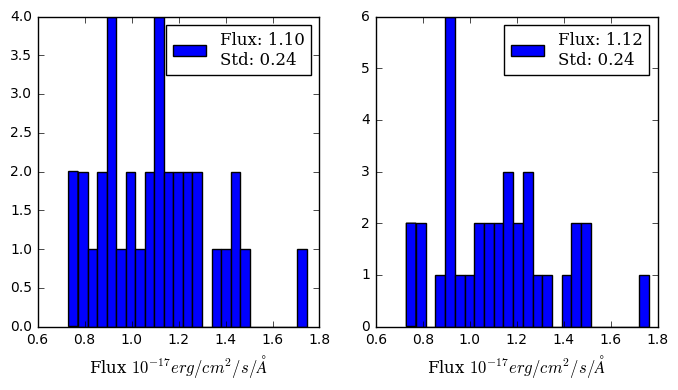

In [217]:
flux_histogram(1,1)

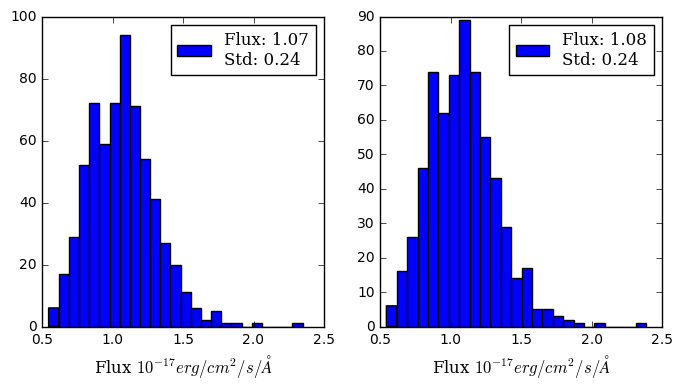

In [222]:
flux_histogram('all', 10)

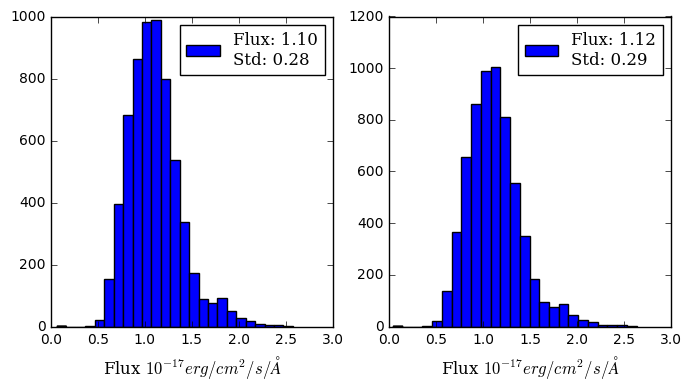

In [223]:
flux_histogram('all','all')

## AB Magnitude of Continuum Data

In [21]:
def mean_abmag(spectrum, bands):
    mags = []
    Wlen = []
    Flux = []
    segments = []
    f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
    xx = np.linspace(565, 1040, (1040-565)*100)
    sky = f(xx)
    for band in bands:
        segment = np.where((band[0]<=xx) & (xx<=band[1]))
        segments.append(segment)
        
    segments = np.hstack(segments)
    wlen = xx[segments] * 10 * u.Angstrom
    flux = sky[segments] * 10**(-17) * u.erg / (u.cm**2 * u.s * u.Angstrom)

    flux, wlen = filters.pad_spectrum(flux[0], wlen[0])
    
    mag = filters.get_ab_magnitudes(flux/np.pi, wlen) #divide by arcsec^2
    mag = mag.as_array()[0]

    return mag

In [62]:
spectrum = get_spectrum()
mean_abmag(spectrum, cont_bands)

plate:  5003


( 21.27547942,  21.18281814)

In [22]:
def abmag_histogram(num_images, num_specnos):
    lssty = []
    decamy = []
    vistay = []
    for plate in np.unique(Red_Data['PLATE']):
        PlateData = Red_Data[Red_Data['PLATE'] == plate]
        data = np.load(DATA_DIR+'/sky_flux/%s_calibrated_sky.npy' % str(plate))
        if num_images == 'all':
            images = np.unique(PlateData['IMG'])
        else:
            images = np.random.choice(np.unique(PlateData['IMG']), num_images)
        for image in images:
            ImageData = PlateData[PlateData['IMG'] == image]
            if num_specnos == 'all':
                specnos = np.unique(ImageData['SPECNO'])
            else:
                specnos = np.random.choice(np.unique(ImageData['SPECNO']),num_specnos)
            for spec in specnos:
                spectrum = data[spec]
                lssty.append(mean_abmag(spectrum, cont_bands)[0])
                decamy.append(mean_abmag(spectrum, cont_bands)[1])
                vistay.append(mean_abmag(spectrum, cont_bands)[2])
    
    names = ['LSST-Y', 'DeCAM-Y','VISTA-Y']
    fig, ax1 = plt.subplots(figsize = (8,4))
    for i,seg in enumerate([lssty, decamy, vistay]):
        seg= np.array(seg)
        bad = np.where(~np.isfinite(seg))
        seg_new = np.delete(seg, bad)
        mean = np.mean(seg_new)
        std = np.std(seg_new)
        ax1.hist(seg_new, 25, alpha=0.7,label = "%s:  %.2f (%.2f)" % (names[i],mean,std))
        ax1.set_xlabel("$Y_{AB} mag/arcsec^{2}$",fontproperties=font)
        ax1.legend(loc='upper right',prop=font) 

/Users/parkerf/anaconda3/lib/python3.5/site-packages/speclite/filters.py:989: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(maggies)
/Users/parkerf/anaconda3/lib/python3.5/site-packages/speclite/filters.py:989: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(maggies)


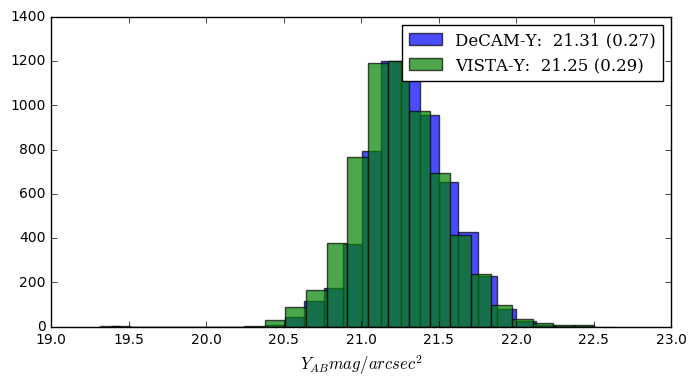

In [68]:
abmag_histogram('all','all')

## Use full Continuum - How do we define the Continuum?

### Try lowest flux values

In [23]:
def binned_cont(wave, spectrum, spacing):
    bins = np.linspace(365,1040,(1040-365)*spacing)
    min_values = []
    for i, w in enumerate(bins):
        if w < 1040.:
            section = np.where((wave>bins[i])&(wave<bins[i+1]))
            window = spectrum[section]
            
            m = np.ma.masked_array(window, mask=(window==0))
            ind = np.where(m==m.min())
            min_values.append(window[ind][0])
   
    f = interp1d(bins[1:], min_values,bounds_error=False, fill_value = 'extrapolate')
    xx = np.linspace(365, 1040, (1040-365)*100)
    
    return f(xx)

In [24]:
def clean_spectrum(spectrum):
    neg = np.where(spectrum['SKY'] < 0)
    bad = np.where((np.isnan(spectrum['SKY'])) | (np.isinf(spectrum['SKY'])))
    spectrum['SKY'][neg] = 0
    spectrum['SKY'][bad] = 0
    
    return spectrum

In [25]:
def mean_plate(plate=None, img=None):
    if plate == None:
        plate = np.random.choice(np.unique(Meta_Data['PLATE']),1)[0]
    PlateMeta = Meta_Data[Meta_Data['PLATE'] == plate]

    if img == None:
        img = np.random.choice(np.unique(PlateMeta['IMG']),1)[0]
    ThisMeta = PlateMeta[PlateMeta['IMG'] == img]
    data = np.load(DATA_DIR+'sky_flux/%s_calibrated_sky.npy' % str(plate))   
    xx = np.linspace(365, 1040, (1040-365)*100)
    SKY_SPECTRA = []
    SKY_IVAR = []
    for fiber_num in np.unique(ThisMeta['FIB']):
        fiber_spectrum = []
        fiber_ivar = []
        spectra = ThisMeta[ThisMeta['FIB'] == fiber_num]
        for spec in spectra:
            specno = spec['SPECNO']
            spectrum = data[specno]
            spectrum = clean_spectrum(spectrum)
            f = interp1d(spectrum['WAVE'], spectrum['SKY'], bounds_error=False, fill_value=0)
            g = interp1d(spectrum['WAVE'], spectrum['IVAR'], bounds_error=False, fill_value=0)
            sky = f(xx)
            ivar = g(xx)
            fiber_spectrum.append(sky)
            fiber_ivar.append(ivar)
        max_spectrum = np.maximum(fiber_spectrum[0], fiber_spectrum[1])
        Sky_ivar = np.array(fiber_ivar[0]).copy()
        fiber_ivar1 = np.array(fiber_ivar[1])
        Sky_ivar[np.where(max_spectrum == np.array(fiber_spectrum[1]))[0]] = fiber_ivar1[np.where(max_spectrum == np.array(fiber_spectrum[1]))[0]]
        SKY_SPECTRA.append(max_spectrum)
        SKY_IVAR.append(Sky_ivar)

    mean_spectrum = np.ma.average(SKY_SPECTRA, axis=0, weights=SKY_IVAR)
    
    return xx, mean_spectrum

In [105]:
wave, mean_sky = mean_plate()

5205 142944


/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


0.05 ( 21.73067159,  21.66553655,  21.31298945)
0.1 ( 21.63296683,  21.51615451,  21.15664233)
0.3 ( 21.29697184,  21.10001457,  20.77326507)
0.5 ( 21.00544003,  20.8090049,  20.54921973)


/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:425: UserWarning: Warning: converting a masked element to nan.
  y = array(y, copy=self.copy)


0.8 ( 20.67643412,  20.46885301,  20.19420454)
1.0 ( 20.51970426,  20.41150452,  20.15221654)


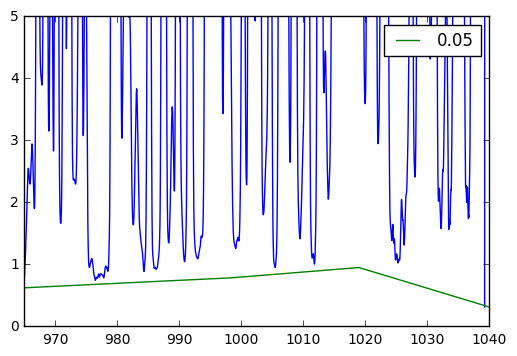

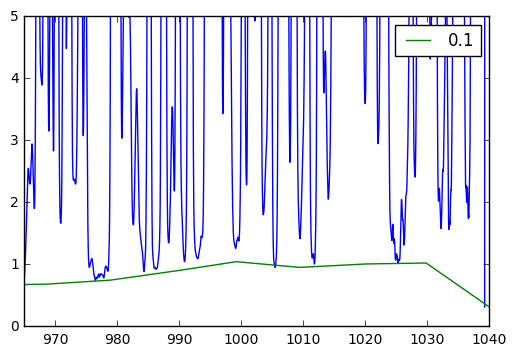

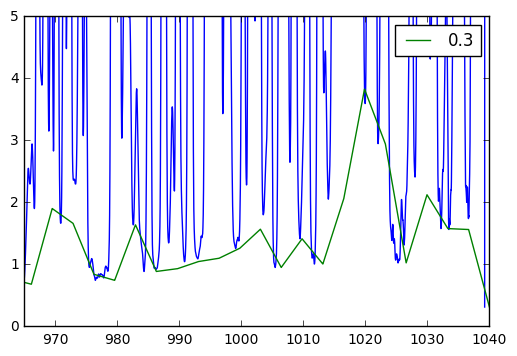

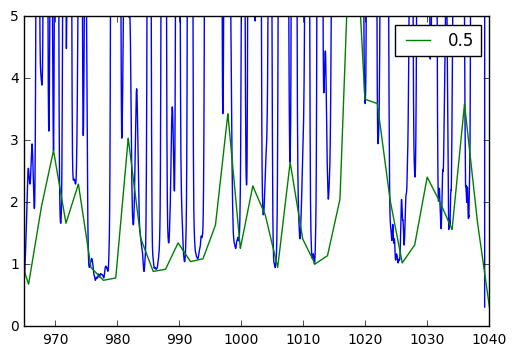

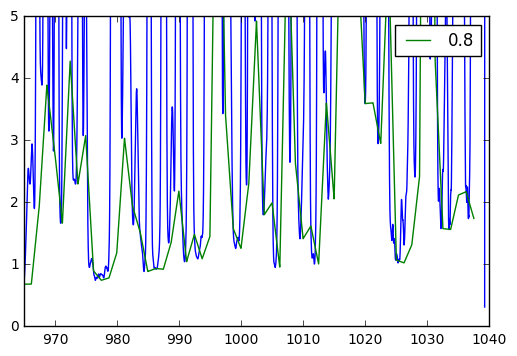

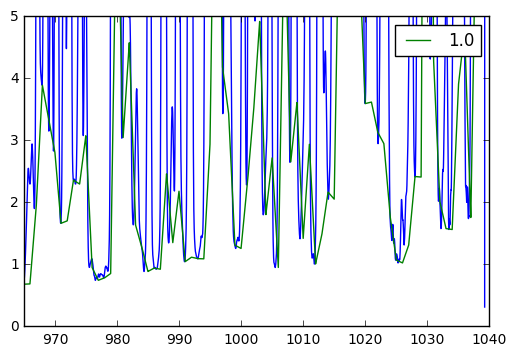

In [101]:
for x in [0.05, 0.1, 0.3, 0.5, 0.8, 1.0]:
    cont = binned_cont(wave, mean_sky,x)
    cont = np.array(cont)
    bad = np.where(~np.isfinite(cont))
    sky = np.delete(cont, bad)
    xx = np.delete(np.linspace(365, 1040, (1040-365)*100), bad)

    wlen = xx * 10 * u.Angstrom
    flux = sky * 10**(-17) * u.erg / (u.cm**2 * u.s * u.Angstrom)

    flux, wlen = filters.pad_spectrum(flux, wlen)

    mag = filters.get_ab_magnitudes(flux/np.pi, wlen) #divide by arcsec^2
    mag = mag.as_array()[0]

    print(x, mag)

### Regardless, there is still more scatter in our data

In [109]:
# Get Mean Spectra
mean_spectra = {}
for plate in np.unique(Meta_Data['PLATE']):
    PlateData = Meta_Data[Meta_Data['PLATE'] == plate]
    images = np.unique(PlateData['IMG'])
    
    for image in images:
        ImageData = PlateData[PlateData['IMG'] == image]
        wave, mean_sky = mean_plate(plate=plate, img=image)
        mean_spectra[plate,image] = mean_sky

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/parkerf/anaconda3/lib/python3.5/site-packages/scipy/interpolate/interpolate.py:425: UserWarning: Warning: converting a masked element to nan.
  y = array(y, copy=self.copy)


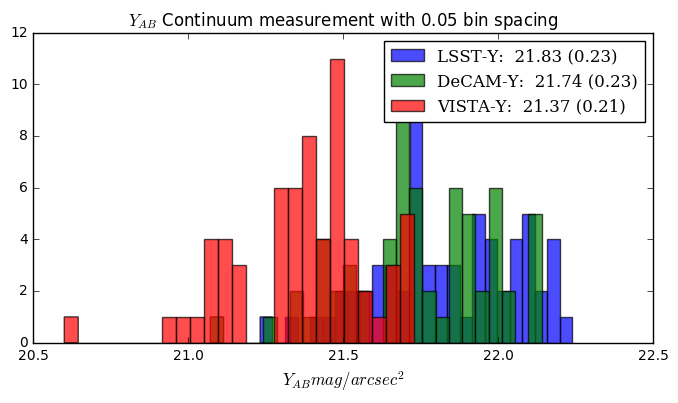

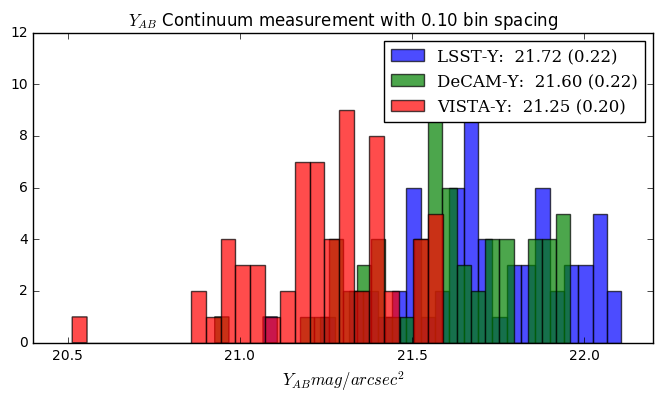

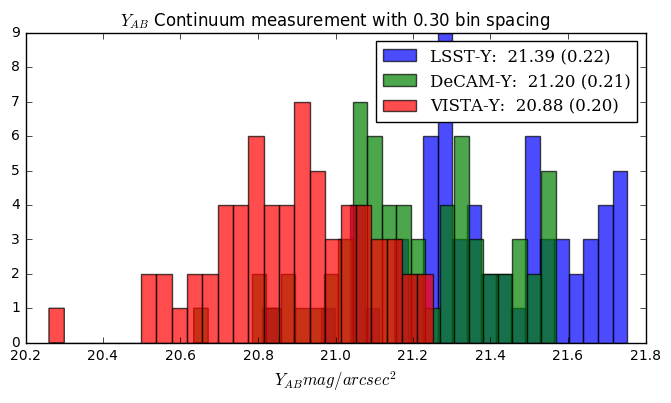

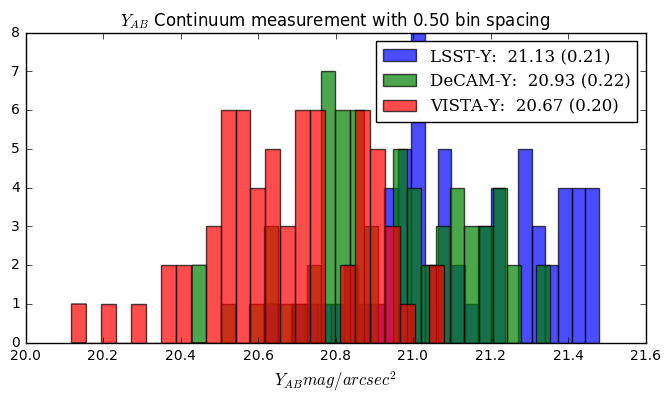

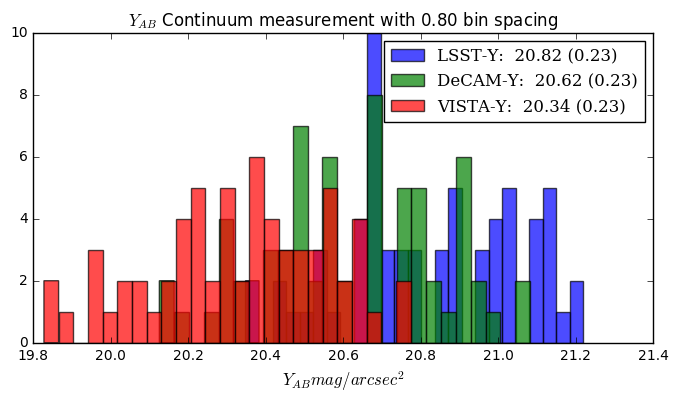

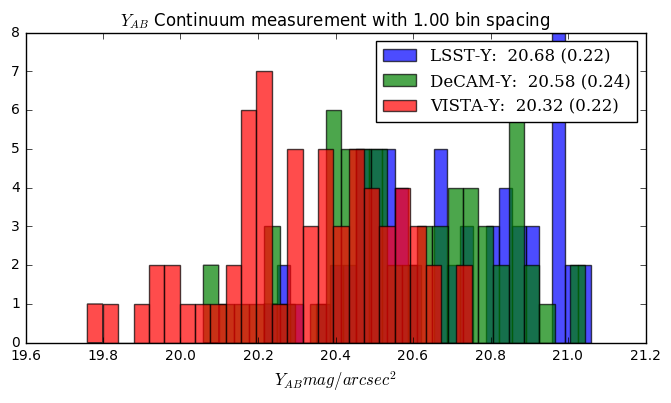

In [36]:


for i,x in enumerate([0.05, 0.1, 0.3, 0.5, 0.8, 1.0]):
    lssty = []
    decamy = []
    vistay = []
    for plate in np.unique(Meta_Data['PLATE']):
        PlateData = Meta_Data[Meta_Data['PLATE'] == plate]
        images = np.unique(PlateData['IMG'])

        for image in images:
            try:
                mean_sky = np.load('mean_sky_spectra/%d_%d_mean_sky'%(plate,image))
                wave = np.linspace(365, 1040, (1040-365)*100)

                cont = binned_cont(wave, mean_sky,x)
                cont = np.array(cont)
                bad = np.where(~np.isfinite(cont))
                sky = np.delete(cont, bad)
                xx = np.delete(wave, bad)

                wlen = xx * 10 * u.Angstrom
                flux = sky * 10**(-17) * u.erg / (u.cm**2 * u.s * u.Angstrom)

                flux, wlen = filters.pad_spectrum(flux, wlen)

                mag = filters.get_ab_magnitudes(flux/np.pi, wlen) #divide by arcsec^2
                mag = mag.as_array()[0]
                lssty.append(mag[0])
                decamy.append(mag[1])
                vistay.append(mag[2])
            except:
                pass
    names = ['LSST-Y', 'DeCAM-Y','VISTA-Y']
    fig, ax1 = plt.subplots(figsize = (8,4))
    for i,seg in enumerate([lssty, decamy, vistay]):
        seg= np.array(seg)
        bad = np.where(~np.isfinite(seg))
        seg_new = np.delete(seg, bad)
        mean = np.mean(seg_new)
        std = np.std(seg_new)
        ax1.hist(seg_new, 25, alpha=0.7,label = "%s:  %.2f (%.2f)" % (names[i],mean,std))
        ax1.set_title("$Y_{AB}$ Continuum measurement with %.2f bin spacing" % x)
        ax1.set_xlabel("$Y_{AB} mag/arcsec^{2}$",fontproperties=font)
        ax1.legend(loc='upper right',prop=font) 